#### FRom SAV to LOVE

# HW №11

## Введение в обработку естественного языка
### Урок 11. Модель Transformer-1
### Практическое задание

<ol>
<li>разобраться с кодом трансформера</li>
<li>сравнить задачи перевода как стало лучше seq2seq без внимания, с вниманием, и трансформер</li>
</ol>

### Import TensorFlow and other libraries

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Download the dataset

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', with_info=True, as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

### Tokenizer 

In [ ]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [ ]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [8073, 1034, 8104, 5774, 13, 3531, 8035]
The original string: Transformer is awesome.


In [ ]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

8073 ----> T
1034 ----> ran
8104 ----> s
5774 ----> former 
13 ----> is 
3531 ----> awesome
8035 ----> .


### Prep datasets

In [ ]:
BUFFER_SIZE = 25000
BATCH_SIZE = 64
MAX_LENGTH = 40

In [ ]:
def encode(pt, en):
    pt = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(pt.numpy()) + [tokenizer_pt.vocab_size+1]
    en = [tokenizer_en.vocab_size] + tokenizer_en.encode(en.numpy()) + [tokenizer_en.vocab_size+1]
    return pt, en

def tf_encode(pt, en):
    pt, en = tf.py_function(func=encode, inp=[pt, en], Tout=[tf.int64, tf.int64])
    pt.set_shape([None])
    en.set_shape([None])
    return pt, en

def filter_max_length(x, y, max_length=40):
    result = tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)
    return result

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

next(iter(val_dataset))

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

### Positional encoding

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = pos * (1 / np.power(10_000, (2 * (i // 2)) / np.float32(d_model)))
    return angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    return pos_encoding

(1, 50, 512)


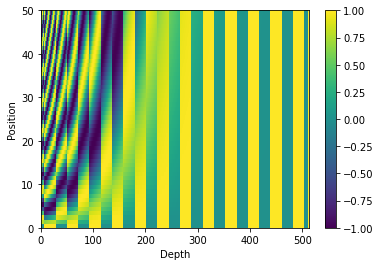

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0])
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 1. разобраться с кодом трансформера

### Masking

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    seq = seq[:, tf.newaxis, tf.newaxis, :]
    return seq

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

### Scaled dot product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    dk = tf.math.sqrt(dk)
    
    scaled_attention_logits = matmul_qk / dk

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

### Multi-head attention

In [ ]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        self.dense = layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        output, weight = scaled_dot_product_attention(q, k, v, mask)
        
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(output)
        return output, weight

### Point wise feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    seq = tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])
    return seq

### Encoder layer

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

### Decoder layer

In [ ]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [ ]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

### Decoder

In [ ]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
            
        return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, rate)
        
        self.final_layer = layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

### Hyperparameters

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4_000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Loss and metrics

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(real, pred)
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

def accuracy_function(real, pred):
    acc = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    acc = tf.math.logical_and(mask, acc)
    acc = tf.cast(acc, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    acc = tf.reduce_sum(acc) / tf.reduce_sum(mask)
    return acc

### Model init

In [ ]:
transformer = Transformer(
    num_layers, d_model, num_heads, dff,
    input_vocab_size, target_vocab_size, 
    pe_input=input_vocab_size, 
    pe_target=target_vocab_size,
    rate=dropout_rate
)

### Checkpointing

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Training

In [ ]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combine_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        pred, _ = transformer(
            inp, tar_inp, True,
            enc_padding_mask,
            combine_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, pred)
        
    grad = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grad, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, pred))

In [ ]:
EPOCHS = 5
training = True

if training:
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        for batch, (inp, tar) in enumerate(train_dataset):
            train_step(inp, tar)

            if batch % 1000 == 0:
                print (f'Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        
        ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1}')
        print (f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print (f'Time taken for 1 epoch: {round(time.time() - start)} secs\n')

Batch 0 Loss 1.8339 Accuracy 0.5986
Batch 1000 Loss 1.7879 Accuracy 0.6198
Batch 2000 Loss 1.7918 Accuracy 0.6192
Saving checkpoint for epoch 1
Epoch 1 Loss 1.7938 Accuracy 0.6189
Time taken for 1 epoch: 359 secs

Batch 0 Loss 1.7105 Accuracy 0.6293
Batch 1000 Loss 1.7839 Accuracy 0.6198
Batch 2000 Loss 1.7862 Accuracy 0.6198
Saving checkpoint for epoch 2
Epoch 2 Loss 1.7896 Accuracy 0.6193
Time taken for 1 epoch: 357 secs

Batch 0 Loss 1.7575 Accuracy 0.6239


### 2. сравнить задачи перевода как стало лучше seq2seq без внимания, с вниманием, и трансформер

### Evaluate

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
  
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        predictions, attention_weights = transformer(
            encoder_input, output, False,
            enc_padding_mask, combined_mask,
            dec_padding_mask
        )
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights
    
def translate(sentence):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])
    
    print(f'Input: {sentence}')
    print(f'Predicted translation: {predicted_sentence}')

In [ ]:
translate('Добрый вечер') # Good evening

Input: Добрый вечер
Predicted translation: let 's see a good evening .


In [ ]:
translate('Пожалуйста, говорите помедленнее') # Please speak more slowly

Input: Пожалуйста, говорите помедленнее
Predicted translation: you see , you see the autumn closer .


In [ ]:
translate('На перекрестке поверните направо') # Turn left at the crossroads

Input: На перекрестке поверните направо
Predicted translation: the glorious is on the right side of the intersection .


In [ ]:
translate('Пожалуйста, оставьте меня в покое') # Please leave me alone

Input: Пожалуйста, оставьте меня в покое
Predicted translation: see the closest closed , leave me in the world .
